# Handwritten Classification with Tensor Learning

In this notebook we will see how to use tensor techniques to solve a classic machine learning problem: the handwritten classification problem. The module *TensorFox* is a tensor library I did for my Phd thesis, you can learn more about it [here](https://github.com/felipebottega/TensorCodes). For more information about the techniques used here I recommend the article *Handwritten digit classification using higher order singular value decomposition*, from B. Savas and L. Eldén.

We are given a train set as a $20 \times 20 \times 5000$ tensor (a 3D numpy array) such that each slice is a $20 \times 20$ image of one of the digits $d = 0, 1, \ldots, 9$. We have a total of $5000$ samples to work with. Also, it is not necessary to explicitly construct the array of labels since the data is organized so that each $500$ consecutive slices of the tensor correspond to a digit $d$, following the order $d = 0, 1, \ldots, 9$. Let's begin importing the relevant modules and creating the relevant arrays.

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import TensorFox as tfx

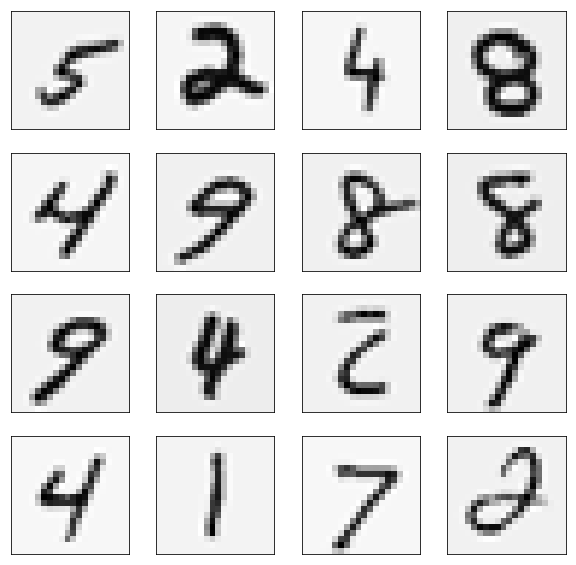

In [2]:
""" 
Load the 20x20x5000 tensor, which we named as 'data'. Each section gives the pixels of an 
image. Each slice is an image 20x20 of a digit, and each 500 consecutive slices correspond 
to a specific digit. More specifically we have the following correspondences:
data[:,:,0:500] = digit 0
data[:,:,500:1000] = digit 1
data[:,:,1000:1500] = digit 2
data[:,:,1500:2000] = digit 3
data[:,:,2000:2500] = digit 4
data[:,:,2500:3000] = digit 5
data[:,:,3000:3500] = digit 6
data[:,:,3500:4000] = digit 7
data[:,:,4000:4500] = digit 8
data[:,:,4500:5000] = digit 9
"""

data = np.load('handwritten.npy')
    
# Below we plot some slices to visualize what kind of images we are dealing with.
num_rows = 4
num_cols = 4    
fig, ax = plt.subplots(num_rows, num_cols, figsize=(10, 10), sharex='col', sharey='row')     
for i in range(num_rows):
    for j in range(num_cols):
        s = np.random.randint(0,5000)
        ax[i,j].xaxis.set_major_locator(plt.NullLocator())
        ax[i,j].yaxis.set_major_locator(plt.NullLocator())
        ax[i,j].imshow(-data[:,:,s], cmap='gray')
              

In [3]:
"""
For each digit we can create a matrix 400x500 such that each column is a flattened image. 
This way each column is a sample and the matrix contains all the samples of a digit.
After creating these matrices we consider each matrix as a slice of a 400 x 500 x 10 tensor.
"""

m, n, p = 400, 500, 10
T = np.zeros((m, n, p), dtype = np.float64)

for k in range(p):
    for j in range(n):
        T[:,j,k] = data[:,:,n*k+j].reshape(400,)
        
Tsize = np.linalg.norm(T)

# Creating the functions

Now the tensor is initialized we need to construct the main functions. Below we list their purposes.

$\bullet$ **create_sets**: This function creates the train and test datasets. The parameter **percentage** is a number between $0$ and $1$, it is responsible by the amount of data contained in the train dataset. For example, if **percentage** $ = 0.7$, then $70 \%$ of the data will be used to train and the others $30 \%$ will be used to test the model.

$\bullet$ **train_model**: This function is responsible by the training stage. The parameter $r$ should be an integer number such that $2 \leq r \leq \min(mn, mp, np)$. Small values of $r$ means more dimensionalty reduction, which can make the total running time smaller but worsening the precision. 

$\bullet$ **make_predictions**: This function produces the prediction of the trained over the test dataset.

In [4]:
def create_sets(T, n, num_classes, percentage):
    """
    num_train_samples is the number of samples per slice of the train tensor.
    num_test_samples is the number of samples per slice of the test tensor.
    """
    
    # Shuffle columns of T.
    T_new = np.zeros(T.shape)
    for d in range(num_classes): 
        new_cols = np.random.randint(0, n, size=n)
        T_new[:,:,d] = T[:,new_cols,d]
    
    num_train_samples = int(percentage*n)
    num_test_samples = n - int(percentage*n)
    T_train = T_new[:, 0:num_train_samples, :] 
    T_test = T_new[:, num_train_samples:, :] 
        
    return T_train, T_test, num_train_samples, num_test_samples

# HOSVD (High Order Singular Value Decomposition)

For any tensor $T \in \mathbb{R}^{m \times n \times p}$, there are orthogonal matrices $U_1 \in \mathbb{R}^{m \times m}, U_2 \in \mathbb{R}^{n \times n}, U_3 \in \mathbb{R}^{p \times p}$ and a tensor $S \in \mathbb{R}^{m \times n \times p}$ such that

$$ T = (U_1, U_2, U_3) \cdot S.$$

$(U_1, U_2, U_3) \cdot S$ is the multilinear multiplication between $U_1, U_2, U_3$ and $S$. A nice feature of this decomposition is that the *energy* of $S$ is concentrated around the first coordinate, i.e., around $S[0,0,0]$. This concentration make it possible to truncate $S$ and still have a reasonable approximation, similarly when one truncate the SVD of a matrix. 

When a truncation occurs, we work with the tensor $(U_1[:, :R_1], U_2[:, :R_2], U_3[:, ;R_3]) \cdot S[:R_1, :R_2, :R_3]$. We will still use the notation $U_1, U_2, U_3, S$ for the truncation versions of these arrays.

Now consider the $R1 \times R_2 \times R_3$ tensor $F = (I_{R_1}, I_{R_2}, U_3)\cdot S \approx (U_1^T, U_2^T, I_{R_3})\cdot T$. We will consider $F$ as the compressed version of $T$. For each new image digit $z \in \mathbb{R}^m$ (remember that $m = 400$), convert it to the $R_1$ dimensional space using the transformation $z_{new} = U_1^T \cdot z$. In this space we compare it to the space generated by the columns of each slice of $F$ (remember that each slice correspond to a class). The best match will be the new class. This stage of comparing is not made using the slice directly, but instead we compute the SVD of the slice and truncate it. The procedure is summarized below.

> 1) New input: $z \in \mathbb{R}^m$
   
> 2) Transform input: $z_{new} = U_1^T \cdot z \in \mathbb{R}^{R_1}$

> 3) Compute SVD of slices: $F[:,:,d] = \mathcal{U}_d \Sigma_d \mathcal{V}_d^T$ for $d = 0, \ldots 9$ 

> 4) Truncate $\mathcal{U}_d$ to have $trunc < R_1$ columns: $\tilde{\mathcal{U}}_d = \mathcal{U}_d[:, :trunc]$ 

> 5) Solve least squares problems: $\min_x \| \tilde{\mathcal{U}}_d \cdot x - z_{new} \|$ for $d = 0, \ldots, 9$

> 6) The class $d$ associated with the smallest norm is chosen to be the class of $z$

Note that, since the columns of $\tilde{\mathcal{U}}_d$ are orthonormal, the solution of the least squares problem is given by

$$x^\ast = (\tilde{\mathcal{U}}_d)^T \cdot z_{new}.$$

In [5]:
def train_model(T_train, num_train_samples, num_classes, r):
    """
    Compute HOSVD (High Order Singular Value Decomposition) of T. More precisely, we have 
    that T = (U1, U2, U3)*S (in fact, S is truncated so this is an approximation), where
    S is a R1 x R2 x R3 tensor (R3 = 10 in this case),
    S_energy is the total energy retained after truncating the original HOSVD,
    U1 is a m x R1 matrix,
    U2 is a n x R2 matrix,
    U3 is a p x R3 matrix,
    sigma1 is a vector with the first R1 singular values of T1 (first unfolding),
    sigma2 is a vector with the first R2 singular values of T2,
    sigma3 is a vector with the first R3 singular values of T3,
    rel_error = || T - (U1, U2, U3)*S || / ||T||.
    """
    
    print('Training model...')
    trunc_dims = 0
    level = 2
    display = 3
    Tsize = np.linalg.norm(T_train)
    S, S_energy, R1, R2, R3, U1, U2, U3, sigma1, sigma2, sigma3, hosvd_stop, rel_error = tfx.hosvd(T_train, Tsize, r, trunc_dims, level, display)
    
    # Sometimes the HOSVD may truncate the last dimension p. We have to repeat the training in this case.
    if R3 != num_classes:
        success = False
        F, U1 = 0, 0
    else:
        success = True
        F = tfx.aux.multilin_mult(S, np.identity(R1), np.identity(R2), U3, R1, R2, R3)    
        print('Informations')
        print('============')
        print('S.shape =', S.shape)
        print('F.shape =', F.shape)
        print('U1.shape =', U1.shape)
        print('U2.shape =', U2.shape)
        print('U3.shape =', U3.shape)
        print('|T - (U1,U2,U3)*S|/|T|=', rel_error)
        print('Finished')
        print()
    
    return F, U1, success

In [6]:
def make_predictions(T_test, num_test_samples, num_classes, F, U1, trunc):
    """
    In a more geometric interpretation, first we consider the space generated by the columns 
    associated to the digit d, then we check the distance between z_new and this space. This 
    distance is the norm associated with the solution of the least squares problem. 
    After chosing d, this choice means z_new is more close to the space associated to the digit d.
    """

    print('Computing predictions...')
    N = num_classes*num_test_samples
    predictions = np.zeros(N, dtype = np.int64)
    
    # Compute SVD of slices of F.
    F_slices_svd = []
    for d in range(num_classes):
        U, S, Vt = np.linalg.svd(F[:,:,d])
        # We truncate U.
        num_col = U.shape[1]
        new_num_col = min(trunc, num_col)
        F_slices_svd.append(U[:, :new_num_col])
    
    for k in range(num_classes):
        for i in range(num_test_samples):
            z = T_test[:,i,k]
            z_new = np.dot(U1.transpose(), z)
            best_dist = np.inf
    
            for d in range(num_classes):
                x = np.dot(F_slices_svd[d].transpose(), z_new)
                # Distance between z' and the space associated to the digit d.
                dist = np.linalg.norm( np.dot(F_slices_svd[d],x) - z_new )
                if dist < best_dist:
                    best_class = d
                    best_dist = dist
                        
            # Save results.
            predictions[k*num_test_samples+i] = best_class
            
    print('Finished')
        
    return predictions

# Training and Predicting

Now it is time to choose parameters, train our model and test it. 

First we choose **percentage** $ = 0.6$, which means we will only use $60 \%$ of the data as training set. This may sound too few data to work with, but as we will see, the HOSVD is able to learn with this much of data and perform well. 

Set $r = 40$, which means that $S$ dimensions are not bigger than $40 \times 40 \times 10$. Since the original data is $400 \times 500 \times 10$, we see that $100 \left(1 - \frac{40 \cdot 40 \cdot 10}{400 \cdot 200 \cdot 10} \right) = 98 \%$ of all data is compressed. Working with only $2 \%$ of the information may sound too few again, but we will see (again) that the HOSVD can handle it very well.   

Finally, we set $trunc = 16$. Remember this parameter is responsible for the size of the truncation of $\mathcal{U}_d$. We are losing information again, but in this case this is necessary, otherwise we will be overfitting. Truncating the SVD of the sections of $F$ is fundamental to attain good precision. 

In [7]:
num_classes = p
percentage = 0.6
r = 40
trunc = 16

T_train, T_test, num_train_samples, num_test_samples = create_sets(T, n, num_classes, percentage)
print('Number of samples in train set =', num_classes*num_train_samples)
print('Number of samples in test set =', num_classes*num_test_samples)
print()
F, U1, success = train_model(T_train, num_train_samples, num_classes, r)

Number of samples in train set = 3000
Number of samples in test set = 2000

Training model...
Informations
S.shape = (40, 40, 10)
F.shape = (40, 40, 10)
U1.shape = (400, 40)
U2.shape = (300, 40)
U3.shape = (10, 10)
|T - (U1,U2,U3)*S|/|T|= 0.457063401929383
Finished



In [8]:
# Compute acuracy of these predictions. If success == False, we have to repeat the training.
if success:
    predictions = make_predictions(T_test, num_test_samples, num_classes, F, U1, trunc)

    # Now we compare the predictions with the actual classes. 
    successes = 0
    for k in range(num_classes):
        for i in range(num_test_samples):
            if predictions[k*num_test_samples+i] == k:
                successes += 1
        
    accuracy = 100*successes/(num_classes*num_test_samples)
    print('Accuracy =', np.round(accuracy, 3), '%')

Computing predictions...
Finished
Accuracy = 95.1 %
